In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET 5 : Catégorisation automatiquement des questions

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>

## [MISSION 3: PREPROCESSING](#11)<a class="anchor" id="sommaire"></a>
### [M3-1 : Préparation des input et output : ](#12)<a class="anchor" id="sommaire"></a>
### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#13)<a class="anchor" id="sommaire"></a>

## [MISSION 4: APPROCHE NON-SUPERVISEE](#15)<a class="anchor" id="sommaire"></a>
### [M4-1 : Modélisation avec algorithme LDA : ](#16)<a class="anchor" id="sommaire"></a>
### [M5-1 : Modélisation avec algorithme NMF : ](#17)<a class="anchor" id="sommaire"></a>

## [MISSION 5: APPROCHE SUPERVISEE](#20)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Stack Overflow est un site de questions-réponses liées au développement informatique.
Les tags nous permettent de retrouver facilement la réponse à une question posée, pourtant ce n'est pas évident de trouver des tags associés à notre question.
Donc il était intéressant de développer un application qui suggererait automatiquement plusieurs tags pertinents à partir d'une question posée. 

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Stack Overflow propose un outil d’export de données en ligne sur - "stackexchange explorer" :
On retrouve 29 tables au total, mais pour notre besoin, la table 'Posts' suffira parce qu'elle contient la liste des questions posées avec les tags associés, le nombre de réponse, la note de pertinence associée à la question,...

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import os
import re
import warnings
from time import time
from utils.functions import custom_tokenize, print_top_words
from utils.functions import predictTag, vectorizeInputTest
from utils.functions import remove_stopword, cleanText, pattern_searcher
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score

In [4]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Sauvegarde des données des tags et mots pour la suite :

## [MISSION 3: PREPROCESSING](#sommaire)<a class="anchor" id="11"></a>

#### Récuperation des données texte :

Exportons les données stockées dans des fichiers texte :

- data/tags_words_tokens.csv : contient les données de base
- data/Backup/top1000_words.csv : contient les données de top 1000 des mots 
- data/Backup/top100_tags.csv : contient les données de top 100 des tags
- data/Backup/X_data.csv
- data/Backup/y_data.csv

In [5]:
data_preprocess = pd.read_csv('data/Backup/tags_words_tokens.csv',
                              sep='\t', engine='python')
data_preprocess.drop(['Unnamed: 0'], axis=1, inplace=True)

top1000words_exp = pd.read_csv('data/Backup/top1000_words.csv',
                               header=None, index_col=0,
                               squeeze=True).to_dict()
top100tags_exp = pd.read_csv('data/Backup/top100_tags.csv',
                             header=None, index_col=0,
                             squeeze=True).to_dict()

### [M3-1 : Préparation des input et output : ](#sommaire)<a class="anchor" id="12"></a>

#### vectorisation de corpus par Bag Of Words:

In [6]:
# Corpus (=X) en entrée on aura un ensmble de mots -> Body + Title
X_data = pd.read_csv('data/Backup/X_data.csv', sep='\t', engine='python')
X_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
X_data

,use,way,like,using,file,code,one,would,get,string,class,want,method,function,know,python,object,need,ive,example,java,git,new,value,question,difference,javascript,work,best,list,table,time,return,make,something,line,c++,also,dont,type,data,used,application,script,text,set,number,user,find,name,good,command,database,error,create,window,int,server,public,answer,could,jquery,two,page,thing,variable,test,image,http,sql,possible,change,static,problem,see,following,key,array,option,element,without,language,run,looking,project,different,whats,seems,div,web,solution,better,doesnt,call,result,simple,exception,add,another,case,php,really,version,form,branch,found,library,say,directory,feature,column,html,multiple,bit,trying,read,first,var,cant,select,view,program,think,edit,current,memory,programming,able,people,look,url,understand,linux,write,always,event,mean,output,thread,property,service,however,given,check,even,reference,mysql,many,tool,instead,standard,content,etc,print,end,system,query,working,update,process,anyone,item,lot,pattern,repository,.net,well,please,point,source,specific,foo,else,date,browser,book,idea,reason,tried,interface,practice,request,give,take,right,sure,much,design,app,convert,single,field,still,private,main,show,running,post,done,void,based,order,site,since,merge,module,Unnamed: 207,commit,performance,access,remove,stack,instance,size,statement,control,may,tag,message,long,put,loop,import,include,path,someone,input,row,seen,start,parameter,character,thats,called,try,open,seem,visual,client,issue,back,resource,framework,true,word,far,let,non,hidden,information,...,modify,easily,distance,constraint,entry,complex,commits,src=,inheritance,stream,jar,top,img,redirect,iframe,.e+,plugins,username,choose,safe,dom,direction,hoping,beginner,graph,guess,layout,fairly,functional,turn,release,require,couple,linked,nothing,parse,position,constant,foreign,dialog,prevent,almost,expect,dynamically,none,checked,comparison,reflection,worked,body,extra,disk,engine,oracle,device,value=,normal,specify,firefox,logging,signed,completely,fill,regex,center,example.com,revision,extend,plugin,deal,appreciated,disable,major,thus,grid,accepted,reset,ideally,naming,convention,boolean,grep,terminal,sdk,oriented,backup,undefined,declare,submit,host,ignore,letter,postgresql,bin,keyboard,shared,achieve,val,maximum,failed,style=,openerguid,session,authentication,love,business,requirement,sense,necessary,ascii,port,behind,ienumerable,close,injection,although,quickly,looked,share,fully,special,batch,ssh,internal,outer,talking,card,resolve,previous,queue,happen,modified,somewhere,zero,label,proper,mention,generated,guideline,mark,continue,preferably,likely,worth,recursion,follow,past,checkout,mutex,manual,kill,attempt,effective,bunch,choice,download,lisp,recursive,opinion,aspect,__init__,logic,external,seek,str,resize,history,description,passing,warning,proxy,currencytype,+.e+j,lambda,hand,iterate,trouble,area,podcast,mostly,storing,finding,moment,additional,console,wasnt,defining,setup,returned,operating,super,alert,info,production,behavior,arraylist,unable,install,collision,lib,hear,spring,month,license,remember,protected,official,beginning,viewmodel,recommend,everyone,develop,leave,bug,along,anonymous,yield,namespace,assuming,scope,today,developing,containing,accomplish,decimal,simplest,initialize,finally,obviously,youre,gcc,shouldnt,suppose,plain,fit,hashmap,depending,strategy,trigger,enter,scripting,shortcut,boost,wait,minute,meant,slow,dbo,calculate,believe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### vectorisation des tags par MultiLabelBinarizer :

In [8]:
# 4.1 Tags (=y)
y_data = pd.read_csv('data/Backup/y_data.csv', sep='\t', engine='python')
y_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
y_data

,c,python,javascript,java,c++,.net,html,git,jquery,sql,php,sql-server,language-agnostic,string,css,mysql,oop,algorithm,ios,bash,linux,performance,database,windows,objective-c,version-control,shell,multithreading,arrays,design-patterns,cocoa-touch,list,vim,iphone,c++-faq,regex,datetime,http,unix,tsql,command-line,security,unit-testing,svn,data-structures,asp.net,android,terminology,image,rest,ruby,visual-studio,asp.net-mvc,file,exception,database-design,linq,scripting,macos,inheritance,generics,django,ajax,dictionary,debugging,pointers,class,batch-file,reflection,loops,syntax,wpf,memory,collections,memory-management,variables,dom,url,vi,hidden-features,static,editor,eclipse,enums,constructor,xml,cocoa,coding-style,date,json,browser,object,optimization,naming-conventions,function,struct,random,functional-programming,math,templates
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2101,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Le resultat est une matrice de (8292, 100) car nous avons 8292 lignes et 100 (tags) nouvelles colonnes.

### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#sommaire)<a class="anchor" id="13"></a>

Nous allons utiliser 80% des données pour l'entrainement et 20% pour le test

In [10]:
# Split train and test :
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

## [MISSION 4: APPROCHE NON-SUPERVISEE](#sommaire)<a class="anchor" id="15"></a>

In [11]:
n_samples = 0.8
n_features = 1000
n_components = 10
n_top_words = 10
data_preprocess_copy = cleanText(data_preprocess)
data_preprocess_copy.drop(['tokens', 'tokensStopWord'], axis=1, inplace=True)
corpus = data_preprocess_copy['words_tokens']
dataset = corpus.tolist()
data_samples = dataset[:int(len(dataset)*n_samples)]
test_samples = dataset[int(len(dataset)*n_samples):]


def dummy(doc):
    return doc

### [M4-1 : Modélisation avec algorithme LDA : ](#sommaire)<a class="anchor" id="16"></a>

LDA (Latent Dirichlet Allocation) est une méthode non-supervisée qui consiste à classer chaque mot dans une categorie ou sujet(topic) qui lui concerne automatiquement.

In [12]:
# Use tf (raw term count) features for LDA.
print("Extraction des features pour LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                tokenizer=dummy,
                                preprocessor=dummy, analyzer='word')
tf = tf_vectorizer.fit_transform(data_samples)
tf_test = tf_vectorizer.transform(test_samples)
print()

print("Fit  du modele LDA avec tf features, "
      "n_samples=%d and n_features=%d ..."
      % (n_samples, n_features))
lda = LDA(n_components=n_components, max_iter=5,
          learning_method='online', learning_offset=50.,
          random_state=0)
lda.fit(tf)

print("\nLes topics du modele LDA :")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extraction des features pour LDA...

Fit  du modele LDA avec tf features, n_samples=0 and n_features=1000 ...

Les topics du modele LDA :
Topic #0: test import unit testing class product internal coverage company nested
Topic #1: string script list value way array like command item get
Topic #2: linux url process iphone window machine virtual stack memory heap
Topic #3: service ball container range eclipse sequence random generate soap collision
Topic #4: use code one would like using ive know question java
Topic #5: image thread div float two like template dependency std json
Topic #6: git branch error merge change commit database task number get
Topic #7: table jquery sql row view date column mysql database server
Topic #8: file using internet explorer way client want application text user
Topic #9: class method object function public string static type return new



On peut ici imaginer que :
- le topic 1 serait lié à des questions sur le html
- le topic 2 serait lié à des questions sur des gestions de versionning

#### La performance du modèle et recherche de nombre de topics optimal :

Diagnostiquer les performances du modèle avec perplexité et log-vraisemblance :

Un modèle avec une probabilité logarithmique plus élevée et une perplexité moindre est considéré comme bon

Voyons ce que ça donne sur notre modèle:

In [13]:
# Calcul de perplexity avec (5,10,...,30 topics) :
output = pd.DataFrame(columns=['nbrTopic', 'perplexity', 'loglikelihood'])
for i in range(5, 150, 20):
    number_topics = i
    lda_perplexity = LDA(n_components=number_topics, max_iter=5,
                         learning_method='online',
                         learning_offset=50., random_state=0)
    lda_perplexity.fit(tf)
    train_gamma = lda_perplexity.transform(tf)
    test_gamma = lda_perplexity.transform(tf_test)
    news_lda = lda_perplexity.fit(train_gamma)
    dictionary = {"nbrTopic": i,
                  "perplexity": news_lda.perplexity(test_gamma),
                  "loglikelihood": news_lda.score(test_gamma)
                 }
    output = output.append(dictionary, ignore_index=True)
output.head(10)

,nbrTopic,perplexity,loglikelihood
0,5.0,1.448343e+01,-1125.335110
1,25.0,1.245954e+03,-3000.743426
2,45.0,2.875752e+04,-4322.261539
3,65.0,2.507577e+06,-6203.362393
4,85.0,3.630773e+09,-9267.351519
5,105.0,3.238581e+12,-12127.391830
6,125.0,5.627457e+17,-17206.945401
7,145.0,9.752378e+24,-24224.151989


15:18: E124 closing bracket does not match visual indentation


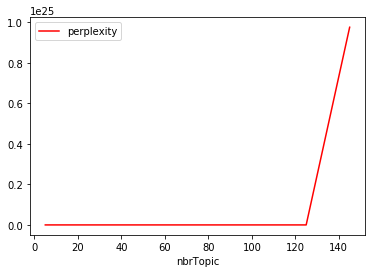

<Figure size 1440x720 with 0 Axes>

In [14]:
# Representation graphique de scores de topic
ax = plt.gca()
output.plot(kind='line', x='nbrTopic',
            y='perplexity', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

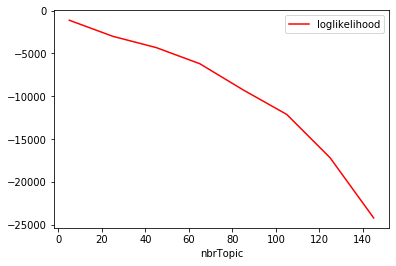

<Figure size 1440x720 with 0 Axes>

In [15]:
# Representation graphique de scores de loglikelihood
ax = plt.gca()
output.plot(kind='line', x='nbrTopic',
            y='loglikelihood', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

Donc on voit que le nombre de topics optimal serait entre 5 et 20, donc on restera sur les 10 de depart.   

### [M5-1 : Modélisation avec algorithme NMF : ](#sommaire)<a class="anchor" id="17"></a>

**NMF**(Non-Negative Matrix Factorization)est.....

In [16]:
# Use tf-idf features for NMF.
print("Extraction des features pour NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   tokenizer=dummy,
                                   preprocessor=dummy)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf_test = tfidf_vectorizer.transform(test_samples)
print("fait en %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fit de modele NMF (Frobenius norm) avec tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("fait en %0.3fs." % (time() - t0))

print("\nLes Topics dans NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

Extraction des features pour NMF...
fait en 0.144s.
Fit de modele NMF (Frobenius norm) avec tf-idf features, n_samples=0 and n_features=1000...
fait en 0.357s.

Les Topics dans NMF model (Frobenius norm):
Topic #0: code use would like way one using ive java know
Topic #1: file directory script line command path open batch header using
Topic #2: string convert value int java array way character like comparison
Topic #3: table sql database column mysql server name row select value
Topic #4: git branch commit repository merge svn change remote add conflict
Topic #5: function javascript jquery element div var image way array using
Topic #6: difference whats one i++ use vs. main performance struct loop
Topic #7: python module print directory source function window using script output
Topic #8: class method static public private java test interface abstract void
Topic #9: list array item generic use order linked name range person



#### La performance du modèle :

In [17]:
# Cosine similarity :


## [MISSION 5: APPROCHE SUPERVISEE](#sommaire)<a class="anchor" id="20"></a>

Certains modèles ne peuvent pas faire de la prediction pour une sortie comprenant plusieurs output. 
Il faut donc utiliser le MulitOutputClassifier

MulitOutputClassifier

Tester plusieurs modèles : LogistiRegression, SGDClassifier, MultinomialDB, LearSVC, Perceptron, PassiveAggressiveClassifier, RandomForest, KNN
    
Comparer : utiliser le Jaccard score et l'accuracy    

In [18]:
# to ignore ConvergenceWarning
warnings.filterwarnings("ignore")

#### Knn model :

In [19]:
print("Training a KNN Model...")
t0 = time()
knn_clf = KNeighborsClassifier()
knn_clf_fit = MultiOutputClassifier(knn_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a KNN Model...
fait en 42.822s.


In [20]:
y_pred_knn = knn_clf_fit.predict(X_test)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)
jaccard_score_knn = jaccard_score(y_test, y_pred_knn, average='samples')
print(accuracy_score_knn, jaccard_score_knn)

0.09501187648456057 0.06441013460015835


#### SGDClassifier

In [21]:
print("Training a SGDClassifier Model...")
t0 = time()
sgd_linear_clf = SGDClassifier(random_state=1, max_iter=5, tol=1e-3)
sgd_linear_clf_fit = MultiOutputClassifier(sgd_linear_clf).fit(X_train,
                                                               y_train)
print("fait en %0.3fs." % (time() - t0))

Training a SGDClassifier Model...
fait en 4.141s.


In [22]:
y_pred_sgd = sgd_linear_clf_fit.predict(X_test)
accuracy_score_sgd = accuracy_score(y_test, y_pred_sgd)
jaccard_score_sgd = jaccard_score(y_test, y_pred_sgd, average='samples')
print(accuracy_score_sgd, jaccard_score_sgd)

0.2042755344418052 0.3637032009953625


#### RandomForest 

In [23]:
print("Training a Random Forest Model...")
t0 = time()
rand_for_clf = RandomForestClassifier(n_estimators=10, random_state=1)
rand_for_clf_fit = MultiOutputClassifier(rand_for_clf).fit(X_train,
                                                           y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Random Forest Model...
fait en 5.995s.


In [24]:
y_pred_rand = rand_for_clf_fit.predict(X_test)
accuracy_score_rand = accuracy_score(y_test, y_pred_rand)
jaccard_score_rand = jaccard_score(y_test, y_pred_rand, average='samples')
print(accuracy_score_rand, jaccard_score_rand)

0.171021377672209 0.19703087885985746


#### Logistic Regression 

In [25]:
print("Training a Logistic Regression Model...")
t0 = time()
log_reg_clf = LogisticRegression(random_state=1)
log_reg_clf_fit = MultiOutputClassifier(log_reg_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Logistic Regression Model...
fait en 13.275s.


In [26]:
y_pred_logr = log_reg_clf_fit.predict(X_test)
accuracy_score_logr = accuracy_score(y_test, y_pred_logr)
jaccard_score_logr = jaccard_score(y_test, y_pred_logr, average='samples')
print(accuracy_score_logr, jaccard_score_logr)

0.2327790973871734 0.32252573238321447


#### MultinomialNB

In [27]:
print("Training a Naive Bayes classifier for multinomial Model...")
t0 = time()
mnb_clf = MultinomialNB()
mnb_clf_fit = MultiOutputClassifier(mnb_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Naive Bayes classifier for multinomial Model...
fait en 1.387s.


In [28]:
y_pred_mnb = mnb_clf_fit.predict(X_test)
accuracy_score_mnb = accuracy_score(y_test, y_pred_mnb)
jaccard_score_mnb = jaccard_score(y_test, y_pred_mnb, average='samples')
print(accuracy_score_mnb, jaccard_score_mnb)

0.14726840855106887 0.29559555334027143


#### Perceptron

In [29]:
print("Training a Perceptron Model...")
t0 = time()
prpt_clf = Perceptron(tol=1e-3, random_state=1)
prpt_clf_fit = MultiOutputClassifier(prpt_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Perceptron Model...
fait en 5.499s.


In [30]:
y_pred_prpt = prpt_clf_fit.predict(X_test)
accuracy_score_prpt = accuracy_score(y_test, y_pred_prpt)
jaccard_score_prpt = jaccard_score(y_test, y_pred_prpt, average='samples')
print(accuracy_score_prpt, jaccard_score_prpt)

0.21852731591448932 0.37885985748218526


#### LinearSVC

In [31]:
print("Training a Linear svc classifier for multinomial Model...")
t0 = time()
lsvc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0,
                                                     tol=1e-5))
lsvc_clf_fit = MultiOutputClassifier(lsvc_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Linear svc classifier for multinomial Model...
fait en 182.470s.


In [32]:
y_pred_lsvc = lsvc_clf_fit.predict(X_test)
accuracy_score_lsvc = accuracy_score(y_test, y_pred_lsvc)
jaccard_score_lsvc = jaccard_score(y_test, y_pred_lsvc, average='samples')
print(accuracy_score_lsvc, jaccard_score_lsvc)

0.08076009501187649 0.2980262347839545


#### PassiveAggressiveClassifier

In [33]:
print("Training a PassiveAggressiveClassifier Model...")
t0 = time()
pac_clf = PassiveAggressiveClassifier(max_iter=1000, random_state=1,
                                      tol=1e-3)
pac_clf_fit = MultiOutputClassifier(pac_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a PassiveAggressiveClassifier Model...
fait en 8.046s.


In [34]:
y_pred_pac = pac_clf_fit.predict(X_test)
accuracy_score_pac = accuracy_score(y_test, y_pred_pac)
jaccard_score_pac = jaccard_score(y_test, y_pred_pac, average='samples')
print(accuracy_score_pac, jaccard_score_pac)

0.21852731591448932 0.38404592240696755


#### Representation graphique :

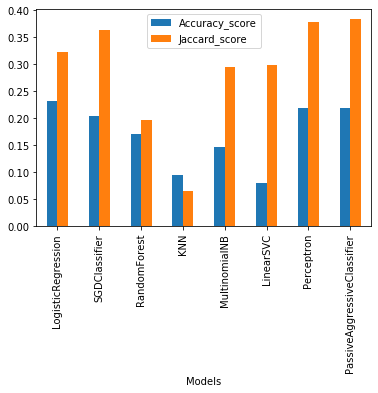

<Figure size 2160x1080 with 0 Axes>

In [35]:
score_AccuracyJaccard_df = pd.DataFrame({
    'Models': ['LogisticRegression', 'SGDClassifier',
               'RandomForest', 'KNN', 'MultinomialNB', 'LinearSVC',
               'Perceptron', 'PassiveAggressiveClassifier'],
    'Accuracy_score': [accuracy_score_logr,
                       accuracy_score_sgd,
                       accuracy_score_rand,
                       accuracy_score_knn,
                       accuracy_score_mnb,
                       accuracy_score_lsvc,
                       accuracy_score_prpt,
                       accuracy_score_pac],
    'Jaccard_score': [jaccard_score_logr,
                      jaccard_score_sgd,
                      jaccard_score_rand,
                      jaccard_score_knn,
                      jaccard_score_mnb,
                      jaccard_score_lsvc,
                      jaccard_score_prpt,
                      jaccard_score_pac]})
ax = plt.gca()
score_AccuracyJaccard_df.plot(kind='bar', x='Models',
                              y=['Accuracy_score', 'Jaccard_score'], ax=ax)
plt.figure(figsize=(30, 15))
plt.show()

###  Test sur formulaire :

#### Prediction avec Logistic regression :

In [36]:
# model = sgd_linear_clf_fit
# model = log_reg_clf_fit
model = lsvc_clf_fit
# model = knn_clf_fit
# textInput = " javascript java python the definitive guide to form based"
textInput = data_preprocess[(data_preprocess['Id'] == 9)]['BodyTitle']
most_freq_words = top1000words_exp
most_freq_tags = top100tags_exp

In [37]:
print(textInput)

0    in c#, how do i calculate someones age based o...
Name: BodyTitle, dtype: object


In [38]:
tagslist = predictTag(model, textInput, top1000words_exp, top100tags_exp)
print('les tags proposées sont : ', tagslist)

les tags proposées sont :  ['c', '.net', 'datetime']
